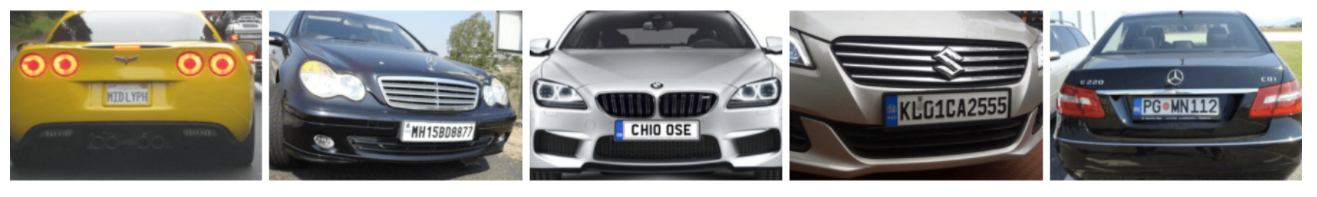

This dataset contains 433 images with bounding box annotations of the car license plates within the image. Our goal here is to train a convolutional neural network capable of locating licenses plate on new images. 

## Preparation of the data

Import libraries

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

We display the files in Kaggle repertoire :

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

We create the variable X containing all the images of cars by resizing them.



In [ ]:
IMAGE_SIZE = 224

In [ ]:
img_dir = "../input/car-plate-detection/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [ ]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [ ]:
path = '../input/car-plate-detection/annotations'
text_files = ['../input/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [ ]:
resizeannotation("/kaggle/input/car-plate-detection/annotations/Cars147.xml")

In [ ]:
y[0]

We check X et y shape

In [ ]:
np.array(X).shape

In [ ]:
np.array(y).shape

And we display the first eighteen image of the dataset : 

In [ ]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

In [ ]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


In [ ]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [ ]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [ ]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [ ]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [ ]:
# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

In [ ]:
model.save('my_model.h5', overwrite=True) 

In [ ]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

In [ ]:
plot_scores(train)

## DETECTION 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


In [ ]:
 y_cnn = model.predict(X_test)

We can see how our model localize license plates on our testing set :

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)

